In [123]:
import numpy as np
import matplotlib.pyplot as plt

import os
import cv2

import time as time_lib

import scipy
import pandas as pd
import seaborn as sns

from collections import defaultdict
from tqdm import tqdm

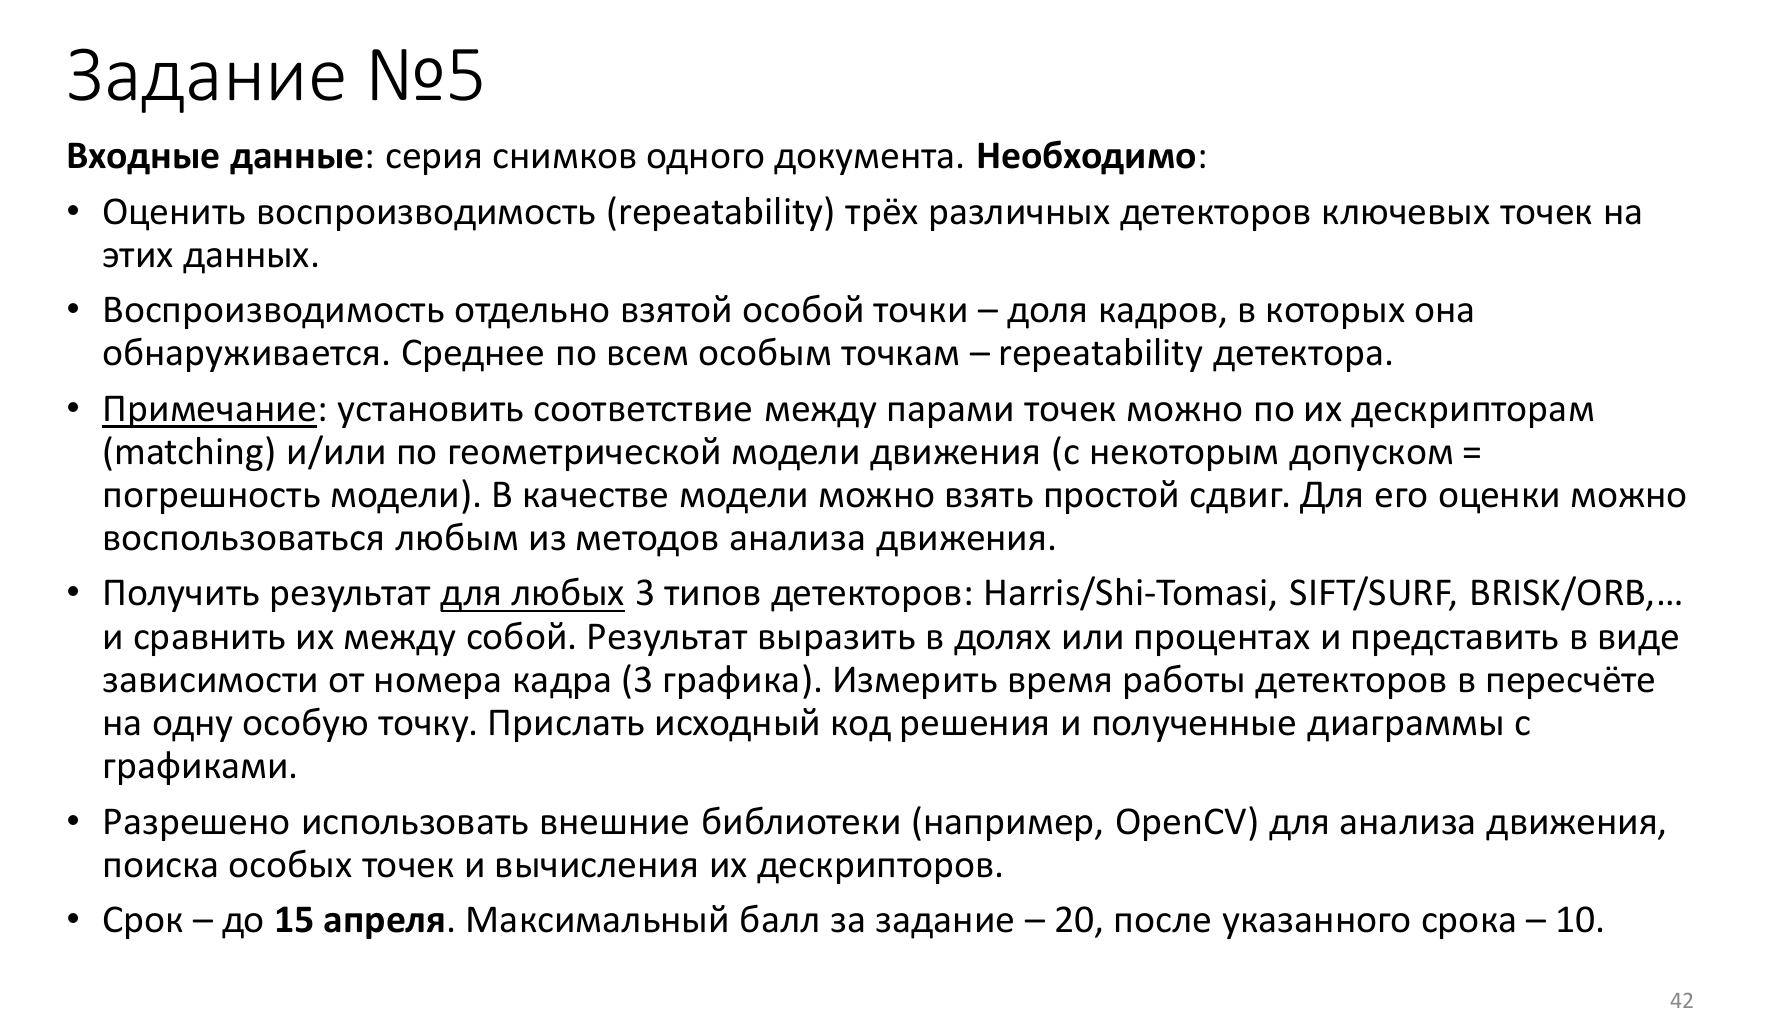

Для детекции ключевых точек достаточно загрузить изображения в Grayscale.

In [40]:
IMAGES = []
DIR_IMAGES = './images'

for root, dirs, files in os.walk(DIR_IMAGES):
    # чтобы файл 01 был первым и т.д
    files.sort()
    for f in files:
        path = os.path.join(root, f)
        IMAGES.append(cv2.imread(path, cv2.IMREAD_GRAYSCALE))
        
len(IMAGES)

12

In [68]:
def find_descriptors(detector, images):
    all_descs = []
    kp_count = 0
    for img in images:
        kps, descr = detector.detectAndCompute(img, None)
        kp_count += len(kps)
        all_descs.append(descr)
    return all_descs, kp_count

# round all floats to 4 digits
def fmt_f(f: float):
    return round(f, 4)

def profile(func, *args, times=5, **kwargs):
    ts = []
    for t in range(times):
        begin = time_lib.time()
        result = func(*args, **kwargs)
        end = time_lib.time()
        ts.append(end - begin)
    ts = np.array(ts)
    return result, ts.mean(), ts.std()

In [105]:
(BRISK_DESCS, kp_count), t, t_std = profile(find_descriptors, cv2.BRISK_create(), IMAGES)
print(f'BRISK: {fmt_f(t * 1000 / kp_count)} +- {fmt_f(t_std * 1000 / kp_count)} ms per kp')

(SIFT_DESCS, kp_count), t, t_std = profile(find_descriptors, cv2.SIFT_create(), IMAGES)
print(f'SIFT: {fmt_f(t * 1000 / kp_count)} +- {fmt_f(t_std * 1000 / kp_count)} ms per kp')

(ORB_DESCS, kp_count), t, t_std = profile(find_descriptors, cv2.ORB_create(), IMAGES)
print(f'ORB: {fmt_f(t * 1000 / kp_count)} +- {fmt_f(t_std * 1000 / kp_count)} ms per kp')


BRISK: 0.0275 +- 0.0012 ms per kp
SIFT: 0.0175 +- 0.0004 ms per kp
ORB: 0.0038 +- 0.0 ms per kp


По скорости ORB выигрывает с значительным запасом - в 7-8 раз быстрее BRISK и в 4-5 раз быстрее SIFT на данных картинках.

In [108]:
def find_repeatability(descs, norm=cv2.NORM_L2):
    reps = []
    # simple all vs all matching, use it to speed up vs bare python
    bf = cv2.BFMatcher(norm, crossCheck=True)
    for i, d1 in enumerate(descs):
        total_matches = {k: 0 for k in range(len(d1))}
        for j, d2 in enumerate(descs):
            # skip same descriptor
            if i == j:
                continue
            matches = bf.match(d1, d2)
            for match in matches:
                total_matches[match.queryIdx] += 1
        
        values = list(total_matches.values())
        rep = np.mean(np.array(values) / (len(descs) - 1))
        reps.append(rep)
    return reps


In [109]:
%%time
# https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html - hamming recommended
brisk_reps = find_repeatability(BRISK_DESCS, norm=cv2.NORM_HAMMING)

CPU times: user 2.5 s, sys: 32.6 ms, total: 2.53 s
Wall time: 305 ms


In [114]:
%%time

sift_reps = find_repeatability(SIFT_DESCS, norm=cv2.NORM_L2)

CPU times: user 1.49 s, sys: 32.2 ms, total: 1.52 s
Wall time: 194 ms


In [115]:
%%time
# https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html - hamming recommended
orb_reps = find_repeatability(ORB_DESCS, norm=cv2.NORM_HAMMING)

CPU times: user 591 ms, sys: 42.6 ms, total: 634 ms
Wall time: 98.1 ms


In [122]:
data_for_df = {
    'brisk_rep': brisk_reps,
    'sift_rep': sift_reps,
    'orb_rep': orb_reps
}
data_for_df['photo_num'] = np.arange(1, len(IMAGES) + 1)

data = pd.DataFrame(data=data_for_df)
data

,brisk_rep,sift_rep,orb_rep,photo_num
0,0.540245,0.669233,0.527006,1
1,0.573440,0.683321,0.572159,2
2,0.568742,0.699499,0.570025,3
3,0.597980,0.704837,0.600418,4
4,0.607434,0.731736,0.599384,5
5,0.575141,0.719848,0.593786,6
6,0.599203,0.718872,0.603445,7
7,0.588235,0.724977,0.609648,8
8,0.583341,0.717271,0.590435,9
9,0.601984,0.695550,0.555368,10


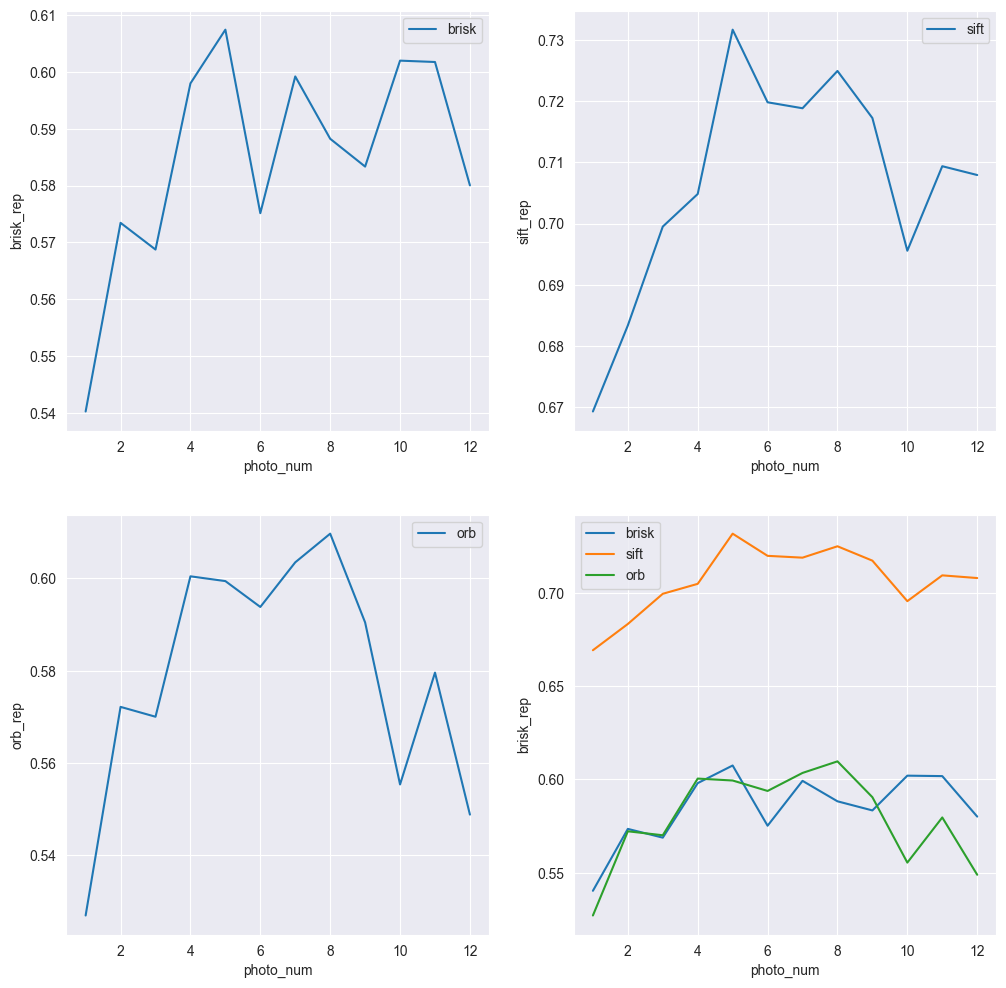

In [138]:
import itertools

sns.set_style('darkgrid')
fig, axs = plt.subplots(figsize=(12,12), ncols=2, nrows=2)
for name, ax in zip(['brisk', 'sift', 'orb'], itertools.chain(*axs)):
    sns.lineplot(data=data, x='photo_num',y=f'{name}_rep', label=name, ax=ax)
    
for name in ['brisk', 'sift', 'orb']:
    sns.lineplot(data=data, x='photo_num',y=f'{name}_rep', label=name, ax=axs[-1][-1])
    


Построили по графику для каждого алгоритма в отдельности (видно, что лучше работают на центральных картинках). Также заметно, что sift значительно выигрывает у семейства brisk/orb, которые получают очень схожее (почти идентичное) качество.